In [ ]:
include("T8.jl")

# Tarea 8: Ecuaciones diferenciales parciales



**Equipo:**

- 
- 


Entre más puntos tiene un problema, más difícil es. Hay 2 que son resolver la ecuación de onda, en 1D y en 2D. Esos dos solos representan 6 puntos, porque son la mitad del trabajo de esta tarea. Tomenlo en cuenta. 


(1 punto) Compara el error del método de disparo con el de diferencia finita para resolver la ecuación diferencial: 

$$\frac{d^2 y}{dx^2}  = p(x) \frac{d y}{dx} + q(x) y +r(x),$$ 

para algunas funciones $p(x)$, $q(x)$ y $r(x)$. Elígelas no triviales (o sea, no 0 o constantes todas). 

In [5]:
using Plots

In [ ]:
function solucionador_disparo(; p = x->x, q = x->x, r = x->x,a = 0, b = 1, α = 0, β = 1, n = 1000, kargs...)
    f(x, t) = [t^2*x[2], p(t)*x[2] + q(t)*x[1]+ r(t)]
    x01 = [α, 0.0]
    x02 = [0, 1.0]
    Y1 = RK4(f, x01, b-a, n; kargs...)
    Y2 = RK4(f, x02, b-a, n; kargs...)
    Y11 = [Y1[i][1] for i in 1:length(Y1)]
    Y21 = [Y2[i][1] for i in 1:length(Y2)]
    return Y11 .+ ((β - Y11[end])/Y21[end] * Y21)
end

In [ ]:
l = 1
p(x) = x
qs(x) = 1
r(x) = exp(x)
Y2 = solucionador_disparo(p = p, q = qs, r = r, b = l, α = 0, β = 0, n = 1000)

In [ ]:
function vector_bb(y0, yl, n; l = 1)
    b = zeros(n-1)
    Δx = l/n 
    b[1] = exp(Δx) * Δx^2 - y0
    b[n-1] = exp((n-1)*Δx) * Δx^2 - yl

    for i in 2:n-2
        b[i] = exp(i*Δx) * Δx^2
    end

    return b
end

In [ ]:
function matriz_MM(n; l=1)
    Δx = l/n 
    M = zeros(n-1, n-1)
    for i in 1:n-1
        M[i,i] = -2
        if i<n-1
            M[i+1, i] = 1-Δx^2
        end
        if i>1
            M[i-1, i] = 1
        end
    end
    return M
end

In [ ]:
function resuelve_eje(y0, yl, n; l = 1)
    b = vector_bb(y0, yl, n; l = 1)
    M = matriz_MM(n; l = 1)
    Y = M \ b
    pushfirst!(Y, y0)
    push!(Y, yl)
    return Y

end

In [ ]:
Y = resuelve_eje(0, 0.0, 1000)

In [ ]:
X = 0:0.001:1
plot(X,Y, key = false, aspect_ratio = 1)
plot!(X,Y2, key = false, aspect_ratio = 1)

**0.5 pts (0.5 de 10)**

**Notas:** 
- Para medir el error necesitan comparar con la solución analítica, sin embargo, su elección de $p(x)$, $q(x)$ y $r(x)$ no les permite tener una solución analítica sencilla. 
- Sus funciones `vector_bb` y `matriz_MM` no son generales, sólo funcionan para la elección particular de $p(x)$, $q(x)$ y $r(x)$ que hicieron en este problema. 
- Tienen errores al momento de obtener la matriz, por ejemplo, me parece que en `matriz_MM`
```julia
M[i,i] = -2
```
debería ser
```julia
M[i,i] = -(2 + p(i*Δx)*Δx + q(i*Δx)*Δx^2)
```

(2 punto) Resuelve la ecuación de la place para el caso donde en el centro de una placa cuadrada, hay un hueco en forma de Mikey Mouse con potencial $V_1$ y afuera de la placa el potencial es $V_2$. 

In [1]:
using SparseArrays

In [2]:
function solucion_Laplace_Cuadrado_Mikey(n, L, R, Vext, Vint)
    # Calcula el tamaño de cada celda
    Δ = L/n
    
    # Inicializa la matriz de coeficientes y el vector de términos independientes
    M = spzeros((n+1)^2, (n+1)^2)
    b = zeros((n+1)^2)
    
    # Calcula las coordenadas del mallado
    posicionesX = [-L/2+Δ*(i-1) for i in 1:(n+1)]
    posicionesY = [-L/2+Δ*(i-1) for i in 1:(n+1)]
    
    # Llena la matriz de coeficientes y el vector de términos independientes
    for i in 1:n+1
        for j in 1:n+1
            x = -L/2 +(i-1)*Δ  # coordenada x del mallado
            y = -L/2 +(j-1)*Δ  # coordenada y del mallado
            k = i+(n+1)*(j-1)  # índice asociado a la variable V en la coordenada (x,y).
            
            # Región circular
            if x^2 + y^2 <= R^2 || (x-R) .^ 2 + (y+R) .^ 2 <= (R/2) .^ 2 || (x-R) .^2 + (y-R) .^2 <= (R/2).^2
                M[k,k] = 1
                b[k] = Vint
            
            # Región exterior
            elseif i == 1 || i == n+1 || j == 1 || j == n+1
                M[k,k] = 1
                b[k] = Vext
            
            # Región interior
            else
                M[k,k] = -4
                M[k, k+1] = 1
                M[k, k-1] = 1
                M[k, k+n+1] = 1
                M[k, k-n-1] = 1
            end
        end
    end
    
    # Resuelve el sistema de ecuaciones lineales
    V = M\b
    
    # Reorganiza el resultado en una matriz
    V = reshape(V, n+1, n+1)
    
    # Retorna las posiciones y el potencial
    return posicionesX, posicionesY, V
end

solucion_Laplace_Cuadrado_Mikey (generic function with 1 method)

In [3]:
posicionesX, posicionesY, V = solucion_Laplace_Cuadrado_Mikey(200, 5, 1, 1, 5) 

([-2.5, -2.475, -2.45, -2.425, -2.4, -2.375, -2.35, -2.325, -2.3, -2.275  …  2.2750000000000004, 2.3000000000000007, 2.325, 2.3500000000000005, 2.375, 2.4000000000000004, 2.4250000000000007, 2.45, 2.4750000000000005, 2.5], [-2.5, -2.475, -2.45, -2.425, -2.4, -2.375, -2.35, -2.325, -2.3, -2.275  …  2.2750000000000004, 2.3000000000000007, 2.325, 2.3500000000000005, 2.375, 2.4000000000000004, 2.4250000000000007, 2.45, 2.4750000000000005, 2.5], [1.0 1.0 … 1.0 1.0; 1.0 1.000703793152777 … 1.0007034323088355 1.0; … ; 1.0 1.0016312728696979 … 1.0016310832287654 1.0; 1.0 1.0 … 1.0 1.0])

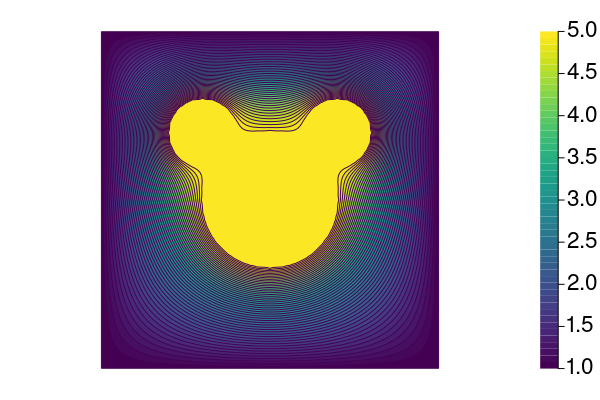

In [6]:
contour(posicionesX, posicionesY, V, aspect_ratio = 1, fill = true, levels = 50, ticks = false, axis = false, color=:viridis)

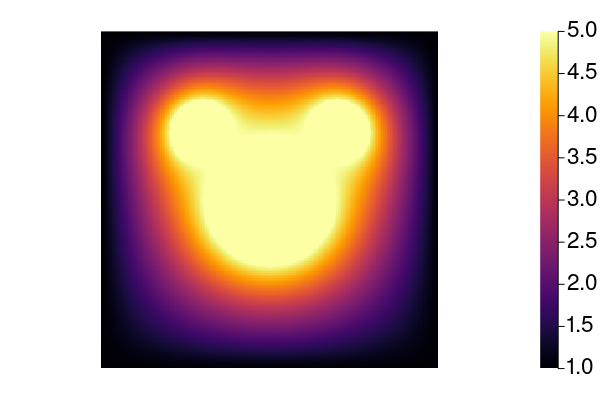

In [8]:
heatmap(posicionesX, posicionesY, V, aspect_ratio = 1, ticks = false, axis = false)

**2 pts (2.5 de 10)**

**Nota:** Muy bien! Una forma de generalizar su función sería cambiar 
```julia
if x^2 + y^2 <= R^2 || (x-R) .^ 2 + (y+R) .^ 2 <= (R/2) .^ 2 || (x-R) .^2 + (y-R) .^2 <= (R/2).^2
```
por
```julia
if adentro(x, y)
```
donde `adentro` es una función (externa) que determina si el punto $(x, y)$ está dentro de la frontera interna. 

(2 punto) Ecuación de Poisson: La ecuación de Poisson es similar a la de Laplace, excepto que en vez de estar igualdo el Laplaciano a $0$, está igualado a una función de $(x,y,z)$ (o en 2D, una función de $(x, y)$), es decir

$$\nabla^2 \phi = f,$$

con $f$ una función cualquiera. 

Escribe la ecuación en diferencias finitas y con ello haz un algoritmo similar al visto en los videos para resolver la ecuación de Laplace de una placa con un hueco circular, ahora para resolver la ecuación de Poisson considerando una distribución de carga no homogenea. 

In [ ]:
function poisson_res(f, h, tol)
    # f: distribución de carga no homogénea
    # h: paso de la malla
    # tol: precisión deseada

    nx, ny = size(f)
    phi = spzeros(nx, ny)  # Inicialización de la malla
    
    # Iteración hasta que se alcance la precisión deseada
    while true
        phi_n = copy(phi)
        for i in 2:nx-1
            for j in 2:ny-1
                phi_n[i,j] = 0.25*(phi[i+1,j]+phi[i-1,j]+phi[i,j+1]+phi[i,j-1]-h^2*f[i,j])
            end
        end
        # Verificación de la precisión de la solución
        if maximum(abs.(phi_n - phi)) < tol
            break
        end
        phi = copy(phi_n)
    end
    
    return phi
end

In [ ]:
nx = 101  # número de puntos en la dirección x
ny = 101  # número de puntos en la dirección y
h = 1/(nx-1)  # paso de la malla
x = range(0, 1, length=nx)  # vector de coordenadas x
y = range(0, 1, length=ny)  # vector de coordenadas y
ff = spzeros(nx, ny)  # inicialización de la distribución de carga
for i in 1:nx
    for j in 1:ny
        ff[i,j] = sin(pi*x[i])*cos(pi*y[j])
    end
end

In [ ]:
tol = 1e-6  # precisión deseada
phi = poisson_res(ff, h, tol)  # resolución de la ecuación de Poisson

In [ ]:
contourf(x, y, phi', levels=20)

**2 pts (4.5 de 10)**

**Notas:** Muy bien!
- Su solución es correcta, sin embargo, el ejercicio buscaba que modificaran ligeramente su código del ejercicio anterior para resolver la ecuación de Poisson. Noten que en el ejercicio anterior pueden incluir una frontera interna y una externa pero en su solución de este ejercicio pierden eso. 
- `f` debería ser una función y no una matriz. Además, no tiene mucho sentido hacer `ff = spzeros(nx, ny)` pues en `ff` hay más entradas distintas de cero que entradas iguales a cero. 

(3 punto) Ecuación de onda en 1D: La ecuación de onda es la siguiente: 

$$ \frac{ \partial^2 \psi}{\partial t} == c^2 \nabla^2 \psi,$$

donde $c$ es la velocidad de la onda. 

Como se trata de una doble derivada en cada variable, significa que se requieren condiciones a la frontera y las condiciones iniciales tienen que ser 2, una sobre la evaluación inicial de $\psi$, y la otra sobre la velocidad inicial de $\psi$. Para simplificar las cosas puedes considerar que se trata de una onda transversal, es decir no hay una velocidad de partículas en $x$, así que $\frac{d\psi}{dt} = \frac{\partial \psi}{\partial t}$. 

(i) Escribe la ecuación de onda 1D en diferencias finitas de tal forma que quede en términos de $t$, $t-\Delta t$ y $t-2\Delta t$. 

(ii) Utilizando las condiciones iniciales de velocidad en $\psi$ y el valor inicial de $\psi$, obtén el valor de $\psi$ al tiempo $\Delta t$. 

(iii) Escribe un código para obtener la simulación una animación) de la ecuación de onda utilizando diferencias finitas y como condición a la frontera un valor fijo de $\psi$ en $x = 0$ y en $x = l$. Varia los valores de $c$.  

### (i)

*Hagamos una expansión de Taylor de segundo orden:*

$$\Psi (x + \Delta x,t)=\Psi (x,t) + \Delta x\dfrac{\partial \Psi(x,t)}{\partial x} + \dfrac{\Delta x^{2}}{2}\dfrac{\partial^{2} \Psi (x,t)}{\partial x^{2}} + ...$$

$$\Psi (x-\Delta x,t)=\Psi (x,t) - \Delta x\dfrac{\partial \Psi(x,t)}{\partial x} + \dfrac{\Delta x^{2}}{2}\dfrac{\partial^{2} \Psi (x,t)}{\partial x^{2}} + ...$$

*Sumando por separado las dos primeras y las dos últimas:*

$$\Psi (x + \Delta x,t) + \Psi (x-\Delta x,t) = \Psi (x,t) + \Delta x\dfrac{\partial \Psi(x,t)}{\partial x} + \dfrac{\Delta x^{2}}{2}\dfrac{\partial^{2} \Psi (x,t)}{\partial x^{2}} + \Psi (x,t) - \Delta x\dfrac{\partial \Psi(x,t)}{\partial x} + \dfrac{\Delta x^{2}}{2}\dfrac{\partial^{2} \Psi (x,t)}{\partial x^{2}}$$

$$\Psi (x + \Delta x,t) + \Psi (x-\Delta x,t) = 2\Psi (x,t) + \Delta x^2\dfrac{\partial^{2} \Psi (x,t)}{\partial x^{2}}$$

*Despejamos la segunda derivada parcial de cada expresión y tenemos:*

$$\dfrac{\partial^{2} \Psi (x,t)}{\partial x^{2}} = \dfrac{\Psi (x + \Delta x,t) + \Psi (x-\Delta x,t) -  2\Psi (x,t)}{\Delta x^2}$$

*Ahora haremos la expansión para la parte temporal, para eso ocuparemos una función que hicimos en la tarea 5:*

In [ ]:
coef([0, -1, -2], 2)

*Ahora que tenemos los coeficientes de la expansión temporal solo queda expresarla:*

$$\dfrac{\partial^{2} \Psi}{\partial t^{2}} = \dfrac{\Psi(x,t) - 2\Psi(x,t - \Delta t) + \Psi(x,t - 2\Delta t)}{\Delta t^{2}}$$

$\Longrightarrow$

$$\dfrac{\Psi(x,t) - 2\Psi(x,t - \Delta t) + \Psi(x,t - 2\Delta t)}{\Delta t^{2}} = c^{2}\left( \dfrac{\Psi (x + \Delta x,t) + \Psi (x-\Delta x,t) -  2\Psi (x,t)}{\Delta x^2} \right)$$

*Definimos $r = \dfrac{c\Delta t}{\Delta x}$*

$$\Psi(x,t) - 2\Psi(x,t - \Delta t) + \Psi(x,t - 2\Delta t) = r^2 (\Psi (x + c\Delta t,t) + \Psi (x-c\Delta t,t) -  2\Psi (x,t))$$

$\Longrightarrow$

$$\left(1+2r^2\right)\Psi(x,t) = r^2 (\Psi (x + c\Delta t,t) + \Psi (x-c\Delta t,t)) - \Psi(x,t - 2\Delta t) + 2\Psi(x,t - \Delta t)$$

$$\Psi(x,t) = \dfrac{r^2 (\Psi (x + c\Delta t,t) + \Psi (x-c\Delta t,t)) - \Psi(x,t - 2\Delta t) + 2\Psi(x,t - \Delta t)}{\left(1+2r^2\right)}$$


### (ii) y (iii)

Por definición tenemos que: 

$$\frac{\partial \Psi (x,t)}{\partial t} = \frac{\Psi(x, t + \Delta t) - \Psi(x,t)}{\Delta t}$$

mas condiciones de frontera: 

$$\frac{\partial \Psi}{\partial t}(x,0)=g(x),$$
 Entonces 

$$\frac{\Psi(x,0+\Delta t)-\Psi(x,0)}{\Delta t}=g(x),$$

Por lo tanto, con la condición inicial $\Psi(x,0)=f(x)$, tenemos:

$$\Psi(x,\Delta t)= \Delta tg(x) + f(x),$$


In [ ]:
function Ψ(f, g, l, t, Δx, r, c = 1)
    x = 0:Δx:l
    X₀ = f.(x)
    X₁ = zeros(length(x))
    for k ∈ 2:length(X₀)-1
        X₁[k] = (1/2)*(2*(1-r^2)*X₀[k]+(r^2)*(X₀[k-1]+X₀[k+1]))+g(x[k])*(r*Δx)/c
    end
    X₂ = zeros(length(x))
    @gif for i ∈ 0:(r*Δx)/c:t
        for j ∈ 2:length(X₂)-1
            X₂[j] = ((r^2)*(X₂[j+1] + X₂[j-1]) + 2*X₁[j] - X₀[j])/(1+2*r^2)
        end
        X₀ = X₁
        X₁ = X₂
        plot(x,X₂,label = "", ylim = [-1,1], xlim = [0,l])
    end
end

In [ ]:
Ψ(sin, x -> 0, 2π, 10, 1, 0.5)

**3 pts (7.5 de 10)**

**Notas:**
- Su fórmula del inciso (i) no es incorrecta, aunque es mejor desarrollar la derivada temporal en $(t-\Delta t, t, t + \Delta t)$.
- En el inciso (ii) su aproximación es de primer orden, cuando lo mejor sería que fuera de segundo orden. 
- Les recomiendo usar `LinRange` en vez de `0:Δx:l` para asegurar los extremos.
- También les recomiendo llenar `X₀` con `for` en vez de con `f.(x)`. 
- Les recomiendo revisar, e.g., [esta página](https://www.cfm.brown.edu/people/dobrush/am34/Mathematica/ch6/nwave.html).

(1 punto) Cohete: (i) Escribe la ecuación de un cohete con fricción. El cohete se mueve únicamente en la dirección $z$ y su forma de elevarse es expulsando masa (de forma constante, parecido a esos cohetes con botellas de refresco y agua). La fricción con el aire genera una fuerza opuesta que va como $-\mu v^2$. 

(ii) Resuelve la ecuación con valores a la frontera $z(t = 0) = 0$, $z(t = 10) = h$, usando el método del disparo no lineal. 

Nota: Vas a encontrar 2 posibles trayectorias. Interpreta su significado.  

In [ ]:
using ForwardDiff

In [ ]:
function RK4_modificado(f,a,b,n::Int)
    t0 = a
    t = b-a
    h = t/n
    x0 = [0.0,1.0]
    X = [zero(x0) for i in 1:n+1]
    X[1] = x0 
    for i in 2:n+1
        g(x) = f(x,t0)[1]
        Grad_f = ForwardDiff.gradient(g,x0)
        z(x,t) = [x[2], Grad_f[2]*x[2]+Grad_f[1]*x[1]]
        k1 = z(x0, t0)
        
        g(x) = f(x,t0 + h/2)[1]
        Grad_f = ForwardDiff.gradient(g,x0 .+ h*k1./2)
        #z(x,t) = [x[2], Grad_f[2]*x[2]+Grad_f[1]*x[1]]
        k2 = z(x0 .+ h*k1./2, t0 + h/2)
        
        g(x) = f(x,t0 + h/2)[1]
        Grad_f = ForwardDiff.gradient(g,x0 .+ h*k2./2)
        #z(x,t) = [x[2], Grad_f[2]*x[2]+Grad_f[1]*x[1]]
        k3 = z(x0 .+ h*k2./2, t0 + h/2)
        
        g(x) = f(x,t0 + h)[1]
        Grad_f = ForwardDiff.gradient(g,x0 .+ h*k3)
        #z(x,t) = [x[2], Grad_f[2]*x[2]+Grad_f[1]*x[1]]
        k4 = z(x0 .+ h*k3, t0 + h)  
        
        x0 = x0 .+ h/6 .* (k1 .+ 2*k2 .+ 2*k3 .+ k4) 
        t0 += h
        X[i] = x0
    end 
    return X
end

In [ ]:
function solucionador_disparo_no_lineal(f,a,b,α,β,n,tₖ,error,num_iteraciones) 
    contador = 0 
    while contador <= num_iteraciones
        contador += 1
         #Paso 1: Resolver el problema de valores iniciales con numero de intervalos
        x01 = [α, tₖ] 
        Y1 = RK4(f, x01, a,b, n) # Resolvemos el sistema de ec. usando RK4
        Z1 = RK4_modificado(f,a,b,n::Int)
        #tₖ₋₁ = (Y1[n+1][1]-β)/(Z1[n+1][2]) 
        if abs(Y1[n+1][1]-β) < error #Paso 2: Aproximamos tₖ por Newton-Raphson
            return Y1
        end
        tₖ -= (Y1[n+1][1]-β)/(Z1[n+1][2]) 
    end
    x01 = [α, tₖ] 
    Y1 = RK4(f, x01, a,b, n)
    re
end 

In [ ]:
#Ejemplo de prueba
f_prueba(x,t) = [x[2],(32-x[1]*x[2]+2*(t^3))*(1/8)]

a= 1
b= 3
α = 17
β = 43/3
n = 20
num_iteraciones = 1e3
error = 1e-3
tₖ = (β-α)/(b-a)

solucionador_disparo_no_lineal(f_prueba,a,b,α,β,n,tₖ,error,num_iteraciones)

In [ ]:
function problema_cohete(μ,m,D,a,b,α,β,error, num_iteraciones)
    G= 6.67e-11
    M_tierra = 5.97e24
    R_tierra = 6.371e3
    f(x,t) = [x[2], (-μ/(m-D*t))*(x[2])^2-(D/(m-D*t))*x[2]-((G*M_tierra)/(x[1]+R_tierra)^2)]
    tₖ = (β-α)/(b-a)
    return solucionador_disparo_no_lineal(f,a,b,α,β,n,tₖ,error, num_iteraciones)
end

In [ ]:
a= 0
b= 10
α = 0
β = 15 #Altura final
n = 20
num_iteraciones = 1e3
error = 1e-2
μ = 1
m = 1
D = 1
problema_cohete(μ,m,D,a,b,α,β,error, num_iteraciones)

In [ ]:
a= 0
b= 10
α = 0
β = 15 #Altura final
n = 20
num_iteraciones = 1e3
error = 1e-2
μ = 1
m = 1
D = 1
problema_cohete(μ,m,D,a,b,α,β,error, num_iteraciones)

**0 pts (7.5 de 10)**

**Notas:**
- Les faltó escribir las ecuaciones de movimiento, en otras palabras, ¿qué sistema están resolviendo y porqué?
- Su código no corre ya que dentro de `solucionador_disparo_no_lineal` tratan de llamar a `RK4` con una signatura incorrecta. 
- Les recomiendo revisar [esta referencia](https://www.webpages.uidaho.edu/~barannyk/Teaching/shooting_nonlinear.pdf).

(3 punto) Simula una placa de Chladni rectangular, con la frontera fija, el centro tiene el máximo de vibración (se tiene que dar una frecuencia) y algún punto cualquiera (elegido por el usuario) también está fijo. Para esto resuelve la ecuación de onda en 2D. 


Para este problema debemos resolver la ecuación de Onda en 2D: 
$$ \frac{ \partial^2 \psi}{\partial^2 t} = c^2 \nabla^2 \psi,$$
con las condiciones iniciales y de frontera:
$$\psi(0,x,y) = f(x,y) \hspace{0.5cm} \psi_{t}(0,x,y) = g(x,y) $$
$$\psi(t,0,y) = \psi(t,a,y) = 0 \hspace{0.5cm} \psi(t,x,0) = \psi(t,x,b) = 0,$$
en $x\in [0,a]$ y $y\in [0,b]$, que representan los bordes de una placa rectangular. En este caso $f$ está representada por
$$f(x,y) = \delta \left(x-\frac{a}{2} \right)\delta \left(y-\frac{b}{2} \right)$$
donde $\delta $ representa la delta de Dirac, y $g(x,y)$ es dada por el usuario.

Usando el método de diferencias finitas, podemos escribir la ecuación de onda en 2D como:
$$\frac{\phi(x,y, t-\Delta t)+\phi(x,y,t+\Delta t)-2\phi(x,y,t)}{\Delta t^2}  = \frac{\psi(x-\Delta x,y)+\psi(x+\Delta x,y)-2\psi(x,y)}{\Delta x^2} +  \frac{\psi(x,y-\Delta y)+\psi(x,y+\Delta y)-2\psi(x,y)}{\Delta y^2}$$
y si escribimos $\Delta x = \Delta y = c \Delta t$, con $c$ la velocidad de la onda nos queda
$$ \frac{\phi(x,y, t-\Delta t)+\phi(x,y,t+\Delta t)-2\phi(x,y,t)}{\Delta t^2} = c^{2}\left[\frac{\phi(x-c\Delta t,y; t)+\phi(x+c\Delta t,y;t)-2\phi(x,y;t)}{c^2 \Delta t^2} + \frac{\phi(x,y-c\Delta t;t)+\phi(x,y+c\Delta t;t)-2\phi(x,y;t)}{c^2\Delta t^2} \right]$$

$$ \phi(x-c\Delta t,y; t)+\phi(x+c\Delta t,y;t)+ \phi(x,y-c\Delta t;t)+\phi(x,y+c\Delta t;t)) $$

$$ \phi(x-c\Delta t,y; t)+\phi(x+c\Delta t,y;t)+ \phi(x,y-c\Delta t;t)+\phi(x,y+c\Delta t;t)) -2\phi(x,y,t)-\phi(x,y,t-\Delta t) - \phi(x,y,t+\Delta t) = 0 $$

Por otro lado, para la condición inicial $\psi_{t}(0,x,y) = 0 $ escribimos

$$\frac{\partial \phi}{\partial t} = \frac{\phi(x,y,t+\Delta t) - \phi(x,y,t-\Delta t)}{\Delta t} = 0 $$
Que nos dice que
$\phi(x,y,t+\Delta t) = \phi(x,y,t-\Delta t)$. Por lo tanto, sustituyendo nos queda:
$$\phi(x-c\Delta t,y; t)+\phi(x+c\Delta t,y;t)+ \phi(x,y-c\Delta t;t)+\phi(x,y+c\Delta t;t)) -2\phi(x,y,t)-2\phi(x,y,t-\Delta t) = 0 $$

**0.5 pts (8 de 10)**

**Notas:**
- No deberían simplemente hacer $\Delta x = \Delta y = c\Delta t$, sino que tienen que introducir el parámetro $r$ al igual que en el caso 1D.
- A raíz de lo anterior, revisen su álgebra. Por ejemplo, $\phi(x,y,t)$ debería tener coeficiente 4, ya que cada coordenada espacial aporta 2. 